In [22]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh import charts
from bokeh.io import output_notebook

import mpld3

# output_notebook()
# mpld3.enable_notebook()

## Read in csv file

Remember to replace with your own file path

In [23]:
bike_df = pd.read_csv("/Users/jeff/bike_data/data/df.csv", parse_dates=[6, 7, 8, 9, 11, 13, 14])

#print dataframe columns
print(bike_df.columns)

#print the 10th row of the dataframe
print("Here is the 10th row!")
bike_df.ix[9]


Index([u'EndStationName', u'StartStationName', u'SubscriberID', u'MemberType',
       u'TripDurationSec', u'BikeID', u'StartDay', u'StartDateTime',
       u'StartDate', u'StartTime', u'StartStationID', u'EndDay',
       u'EndDateTime', u'EndDate', u'EndTime', u'EndStationID',
       u'tripDurationHours', u'yearStart', u'monthStart', u'latlonStart',
       u'latlonEnd'],
      dtype='object')
Here is the 10th row!


EndStationName        100 Manufacturers Rd
StartStationName        High St & E 2nd St
SubscriberID                         33691
MemberType                        Customer
TripDurationSec                       2330
BikeID                              C00132
StartDay                          Saturday
StartDateTime          2014-02-22 13:34:00
StartDate              2014-02-22 00:00:00
StartTime              2016-01-11 13:34:00
StartStationID                        1321
EndDay                            Saturday
EndDateTime            2014-02-22 14:13:00
EndDate                2014-02-22 00:00:00
EndTime                2016-01-11 14:13:00
EndStationID                          1297
tripDurationHours                     0.65
yearStart                             2014
monthStart                               2
latlonStart          35.054855, -85.305476
latlonEnd            35.061546, -85.310370
Name: 9, dtype: object

## Station and Trip Popularity

Let's look at which stations get used the most.  The first chart shows the starting station sorted by number of trips, and the second has the ending station sorted by number of trips

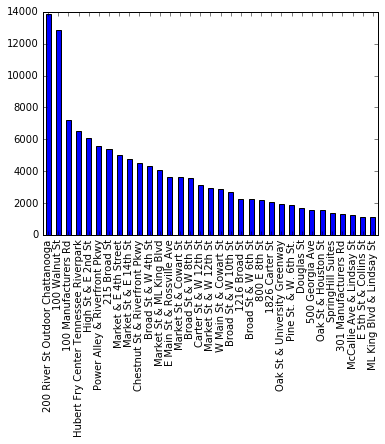

In [24]:
# Group stations
grouped_df = bike_df['StartStationName'].value_counts()

# Make bar chart
grouped_df.plot(kind='bar')


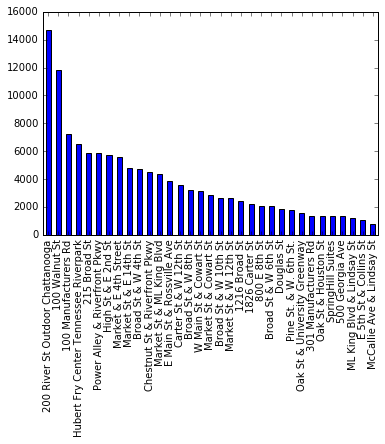

In [25]:
# Group stations
grouped_df = bike_df['EndStationName'].value_counts()

# Make bar chart
grouped_df.plot(kind='bar')

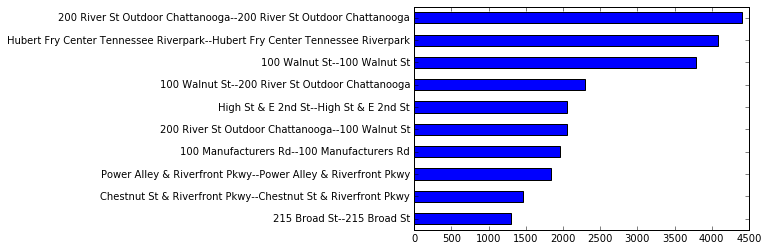

In [26]:
trips = bike_df['StartStationName'] + '--' + bike_df['EndStationName']

trips.value_counts()[:10].sort_values().plot(kind='barh')

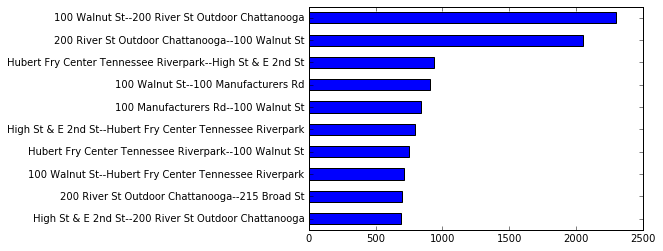

In [27]:
trips.loc[bike_df['StartStationName'] != bike_df['EndStationName']].value_counts()[:10].sort_values().plot(kind='barh')

## Popular Time to Ride

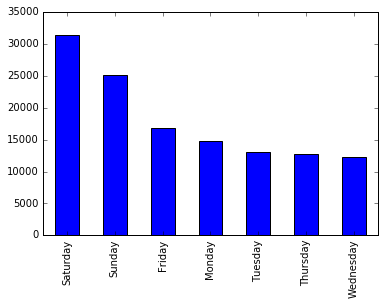

In [28]:
bike_df["StartDay"].value_counts().plot(kind='bar')

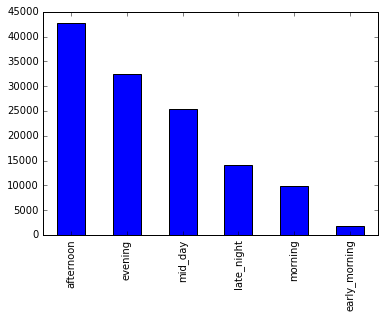

In [29]:
time_windows={22: 'late_night',
              23: 'late_night',
              0: 'late_night',
              1: 'late_night',
              2: 'late_night',
              3: 'late_night',
              4: 'late_night',
              5: 'early_morning',
              6: 'early_morning',
              7: 'early_morning',
              8: 'morning',
              9: 'morning',
              10: 'morning',
              11: 'mid_day',
              12: 'mid_day',
              13: 'mid_day',
              14: 'afternoon',
              15: 'afternoon',
              16: 'afternoon',
              17: 'afternoon',
              18: 'evening',
              19: 'evening',
              20: 'evening',
              21: 'evening',
             }

bike_df['StartTime'].apply(lambda x: time_windows[x.hour]).value_counts().plot(kind='bar')

## Individual Bike Information

In [30]:
print '%d total bikes' % bike_df['BikeID'].unique().shape[0]

297 total bikes


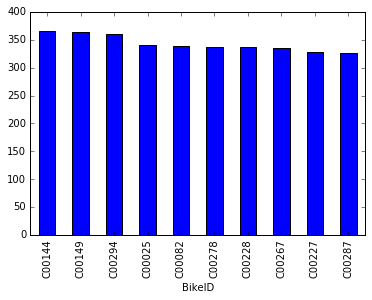

In [31]:
grouped_by_bikes = bike_df.groupby("BikeID")

bike_total_hours = grouped_by_bikes["tripDurationHours"].sum()

bike_total_hours.sort_values(ascending=False)[:10].plot(kind='bar')

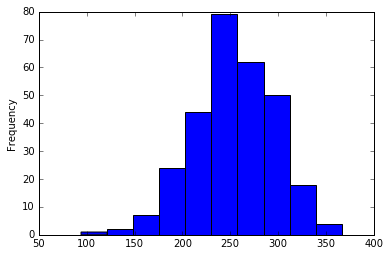

In [32]:
cleaned = bike_total_hours[np.abs(bike_total_hours - bike_total_hours.mean()) < 3*bike_total_hours.std()]

cleaned.plot(kind='hist')

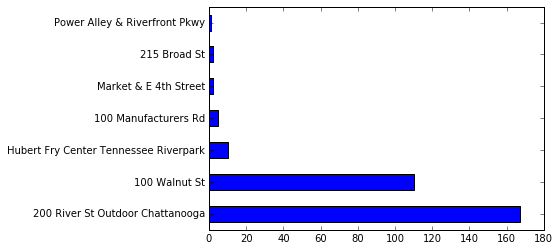

In [33]:
#Most frequently visited station per bike

station_counts = grouped_by_bikes['StartStationName'].value_counts()

station_data = {}
for bike_id in station_counts.index.levels[0]:
    station_data[bike_id] = station_counts[bike_id].argmax()
    
station_data = pd.Series(station_data)
# print(station_data)

favorite_stations = station_data.value_counts()

favorite_stations.plot(kind='barh')

In [34]:
short_trips = bike_df[bike_df['TripDurationSec']<60]

new_bike_df = bike_df.copy()

new_bike_df['NeedsRepair'] = short_trips['StartStationName'] == short_trips['EndStationName']


new_bike_df = new_bike_df.set_index(new_bike_df['StartDateTime'])

by_serial = new_bike_df.groupby('BikeID')

repair_counts = new_bike_df['BikeID'][new_bike_df['NeedsRepair'].fillna(False)].value_counts()

# repair_counts[:10].plot(kind='bar')
# repair_counts.plot(kind='hist')



In [37]:
df = pd.concat((bike_total_hours, repair_counts, station_data), axis=1).fillna(0)
df.columns =  ['TotalHours', 'NeedsRepair', 'FavoriteStation']

df.plot(kind='scatter', x='TotalHours', y='NeedsRepair')
mpld3.display()

In [38]:
df.corr()

,TotalHours,NeedsRepair
TotalHours,1.000000,0.179696
NeedsRepair,0.179696,1.000000


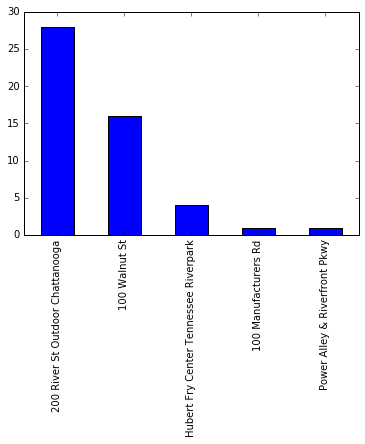

In [39]:
df.sort_values(by='NeedsRepair', ascending=False)[:50]['FavoriteStation'].value_counts().plot(kind='bar')

In [41]:
new_bike_df = bike_df.copy()
new_bike_df = new_bike_df.set_index(new_bike_df['StartDateTime'])

bike_hours_by_id = new_bike_df.loc[new_bike_df['BikeID'].isin(df.sort_values(by='TotalHours', ascending=False)[:11].index)][['BikeID', 'tripDurationHours', 'StartDateTime']]

In [42]:
# test_df = bike_hours_by_id.apply(lambda x: x['tripDurationHours'].cumsum()).reset_index()

per_bike = pd.pivot_table(bike_hours_by_id, index='StartDateTime', columns='BikeID', values='tripDurationHours').sort_index()

for bike in per_bike.columns:
    per_bike[bike] = per_bike[bike].cumsum()
    

per_bike = per_bike.fillna(method='bfill')

In [52]:
ax = per_bike.plot(figsize=(10,8))

mpld3.display()